In [1]:
# Yomitoku Clientの使用例
# このノートブックでは、Yomitoku Clientを使用してSageMaker Yomitokuの出力を
# 様々な形式（CSV、Markdown、HTML、JSON）に変|換する方法を示します

# 必要なライブラリのインポート
from yomitoku_client import YomitokuClient  # メインのクライアントクラス
from yomitoku_client.parsers.sagemaker_parser import SageMakerParser  # SageMakerの出力をパースするクラス
from yomitoku_client.samples import load_pdf_sample, load_image_sample, get_image_sample_path # サンプルデータ（PDFと画像）
from pprint import pprint
import pandas as pd
import json

In [2]:
# ====================
# Parserの詳細説明
# ====================

# SageMakerParser とは？
# - AWS SageMaker の Yomitoku サービスから返される生のJSON出力を
#   Python の型安全な Pydantic モデルに変換するクラスです
# 
# 主な機能：
# 1. 生のJSONデータを構造化されたPythonオブジェクトに変換
# 2. データの検証とバリデーション
# 3. 型安全性の確保（IDEの補完機能が使える）
# 4. 各種フォーマットへの変換を容易にする

parser = SageMakerParser()

print("✅ SageMakerParser と YomitokuClient を初期化完了")

✅ SageMakerParser と YomitokuClient を初期化完了


In [3]:
#サンプル画像をダウンロード
import requests

def download_file(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        file_type = "Image" if filename.endswith(".png") else "PDF"
        print(f"{file_type} saved as {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

download_file(
    "https://mlism-marketplace-documents.s3.ap-northeast-1.amazonaws.com/samples/gallery1.jpg",
    "../src/yomitoku_client/samples/image_sample.png"
)
download_file(
    "https://www.soumu.go.jp/main_content/000975178.pdf",
    "../src/yomitoku_client/samples/pdf_sample.pdf"
)


# 画像サンプルデータを読み込み（これはYomitoku APIの出力形式のJSONデータ）
image_sample_data = load_image_sample()
# parse_dict: SageMaker Yomitokuの辞書形式の出力をPydanticモデルに変換
img_data = parser.parse_dict(image_sample_data)

pdf_sample_data = load_pdf_sample()
# PDFの場合も同様にSageMaker Yomitokuの出力をPydanticモデルに変換
pdf_data = parser.parse_dict(pdf_sample_data)


Image saved as ../src/yomitoku_client/samples/image_sample.png
PDF saved as ../src/yomitoku_client/samples/pdf_sample.pdf


## データエクスポート機能
### 様々な形式への変換とファイル保存

このセクションでは、OCR処理済みのデータを実用的な各種フォーマットに変換し、ファイルとして保存する方法を示します。

**対応フォーマット：**
- **CSV**: Excel等の表計算ソフトで開ける形式。データ分析に最適
- **Markdown**: GitHubやドキュメント作成に便利な軽量マークアップ形式
- **HTML**: ブラウザで直接表示可能。レポートやプレゼンテーションに活用
- **JSON**: プログラムで処理しやすい構造化データ。API連携やデータベース保存に最適

すべてのエクスポートファイルは `exported_data/` ディレクトリに整理して保存されます。

In [4]:
# エクスポート用のディレクトリを作成
import os
export_dir = "exported_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 エクスポートディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")

📁 既存のエクスポートディレクトリを使用: exported_data/


### CSV 形式

In [5]:
# 画像の識別結果（画像の場合は１枚のドキュメント）をCSVで保存
csv_image_path = os.path.join(export_dir, "image_recognitized_data.csv")
# 1枚の画像の場合, pages[0] を指定
result = img_data.pages[0].to_csv(output_path=csv_image_path)
print(f"✓ image_recognitized_data.csv ({os.path.getsize(csv_image_path):,} bytes)")

✓ image_recognitized_data.csv (7,986 bytes)


In [6]:
# PDFデータをCSVで保存
csv_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_csv_folder")
# 複数ページの場合, pagesを指定しなくても良い、フォルダに保存される
pdf_data.to_csv_folder(folder_path=csv_pdf_path)
print(f"✓ pdf_recognitized_data_csv_folder ({os.path.getsize(csv_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
csv_page1_path = os.path.join(export_dir, "pdf_recognitized_data_csv_folder/pdf_recognitized_data_csv_page1.csv")
pdf_data.pages[0].to_csv(output_path=csv_page1_path)
print(f"✓ １ページ目のCSV ({os.path.getsize(csv_page1_path):,} bytes)")

✓ pdf_recognitized_data_csv_folder (384 bytes)
✓ １ページ目のCSV (170 bytes)


### Markdown形式

In [7]:
md_image_path = os.path.join(export_dir, "image_recognitized_data.md")
img_data.pages[0].to_markdown(output_path=md_image_path)
print(f"✓ image_recognitized_data.md ({os.path.getsize(md_image_path):,} bytes)")

✓ image_recognitized_data.md (8,389 bytes)


In [8]:
md_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_md_folder")
pdf_data.to_markdown_folder(folder_path=md_pdf_path)
print(f"✓ pdf_recognitized_data_md_folder ({os.path.getsize(md_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
md_page1_path = os.path.join(export_dir, "pdf_recognitized_data_md_folder/pdf_recognitized_data_md_page1.md")
pdf_data.pages[0].to_markdown(output_path=md_page1_path)
print(f"✓ １ページ目のMarkdown ({os.path.getsize(md_page1_path):,} bytes)")


✓ pdf_recognitized_data_md_folder (384 bytes)
✓ １ページ目のMarkdown (162 bytes)


### HTML形式

In [9]:
html_image_path = os.path.join(export_dir, "image_recognitized_data.html")
img_data.pages[0].to_html(output_path=html_image_path)
print(f"✓ image_data.html ({os.path.getsize(html_image_path):,} bytes)")

✓ image_data.html (8,745 bytes)


In [10]:
html_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_html_folder")
pdf_data.to_html_folder(folder_path=html_pdf_path)
print(f"✓ pdf_recognitized_data_html_folder ({os.path.getsize(html_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
html_page1_path = os.path.join(export_dir, "pdf_recognitized_data_html_folder/pdf_recognitized_data_html_page1.html")
pdf_data.pages[0].to_html(output_path=html_page1_path)
print(f"✓ １ページ目のHTML ({os.path.getsize(html_page1_path):,} bytes)")

✓ pdf_recognitized_data_html_folder (384 bytes)
✓ １ページ目のHTML (210 bytes)


### json形式

In [11]:
# 画像データ（単一ドキュメント）のJSON保存
json_image_path = os.path.join(export_dir, "image_recognitized_data.json")
img_data.pages[0].to_json(output_path=json_image_path)
print(f"✓ image_recognitized_data.json ({os.path.getsize(json_image_path):,} bytes)")

✓ image_recognitized_data.json (152,248 bytes)


In [12]:
# PDFデータ（複数ドキュメント）のJSON保存
json_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_json_folder")
pdf_data.to_json_folder(folder_path=json_pdf_path)
print(f"✓ pdf_recognitized_data_json_folder ({os.path.getsize(json_pdf_path):,} bytes)")
# また、その中の１つを指定して保存することもできる
json_page1_path = os.path.join(export_dir, "pdf_recognitized_data_json_folder/pdf_recognitized_data_json_page1.json")
pdf_data.pages[0].to_json(output_path=json_page1_path)

print(f"✓ pdf_recognitized_data.json ({os.path.getsize(json_pdf_path):,} bytes)")

✓ pdf_recognitized_data_json_folder (384 bytes)
✓ pdf_recognitized_data.json (384 bytes)


## OCR結果から検索可能なPDF

In [13]:
# 画像の識別結果を検索可能なpdfに変換
pdf_image_path = os.path.join(export_dir, "image_recognitized_data.pdf")
#  font_path: Optional[str] = None, output_path: Optional[str] = None, 
#  img: Optional[Any] = None, create_text_pdf: bool = True
image_path = get_image_sample_path() # you can replace with your own image path, 関連画像のパスに置き換えてください。
img_data.to_pdf(output_path=pdf_image_path,img=image_path)

print(f"✓ image_recognitized_data ({os.path.getsize(pdf_image_path):,} bytes)")

✓ image_recognitized_data (6,062,217 bytes)


In [14]:
# PDFデータ（複数ドキュメント）を検索可能なpdfに変換
import os
from yomitoku_client.samples import get_pdf_sample_path
pdf_pdf_path = os.path.join(export_dir, "pdf_recognitized_data_pdf.pdf")
pdf_path = get_pdf_sample_path()
# pdf_path is the path to the pdf file, you can replace with your own pdf file path,関連PDFのパスに置き換えてください。
pdf_data.to_pdf(output_path=pdf_pdf_path,pdf=pdf_path) 
print(f"✓ pdf_recognitized_data_pdf ({os.path.getsize(pdf_pdf_path):,} bytes)")

✓ pdf_recognitized_data_pdf (49,583,912 bytes)


## 可視化
### OCR結果の視覚的な確認と分析

このセクションでは、OCRで検出されたテキスト、図表、テーブルなどの要素を画像上に可視化する機能を紹介します。

**可視化機能の特徴：**
**レイアウト構造の理解**: 文書の階層構造や配置を視覚的に確認

これらの可視化機能により、OCR結果の品質確認や文書構造の理解が容易になります。

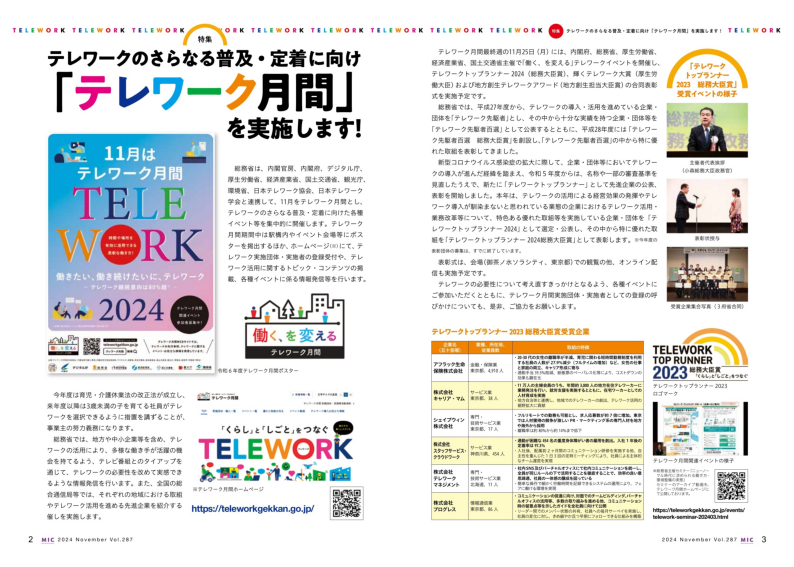

In [15]:
# サンプル画像を表示
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

image_path = get_image_sample_path()
# 画像を読み込んで表示
img = Image.open(image_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

### レイアウト

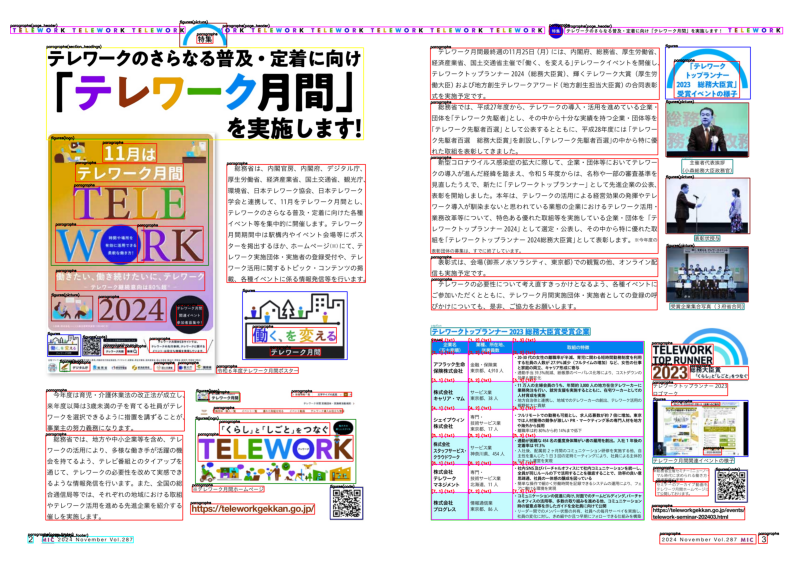

In [16]:
# DocumentVisualizerを使用してレイアウトの詳細を可視化
# visualize: 画像とパースされたデータを受け取り、バウンディングボックスを描画
# type='layout_detail': レイアウトの詳細（テキスト、図、表の位置）を表示
result_img = img_data.pages[0].visualize(image_path=image_path,viz_type='layout_detail')
# # result_img: バウンディングボックスが描画された画像
plt.figure(figsize=(10, 8))
plt.imshow(result_img)
plt.axis("off")
plt.show()

## テーブルデータの確認と変換
### TableVisualizerを使用してテーブルデータを処理

#### 様々な形式にtableを保存できます

### 単一画像の場合

In [17]:
# エクスポート用のディレクトリを作成
import os
export_dir = "image_table_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 画像テーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")

# textの形式
img_data.pages[0].visualize_tables(output_folder=export_dir,output_format='text')
# # htmlの形式
img_data.pages[0].visualize_tables(output_folder=export_dir,output_format='html')
# # # jsonの形式
img_data.pages[0].visualize_tables(output_folder=export_dir,output_format='json')
# # # csvの形式
img_data.pages[0].visualize_tables(output_folder=export_dir,output_format='csv')

📁 既存のエクスポートディレクトリを使用: image_table_data/


['image_table_data/table_1.csv']

### pdfの場合

In [18]:
# エクスポート用のディレクトリを作成
import os
export_dir = "pdf_table_data"
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"📁 pdfテーブルデータディレクトリを作成: {export_dir}/")
else:
    print(f"📁 既存のエクスポートディレクトリを使用: {export_dir}/")
# textの形式
pdf_data.visualize_tables(output_folder=export_dir,output_format='text')
# htmlの形式
pdf_data.visualize_tables(output_folder=export_dir,output_format='html')
# jsonの形式
pdf_data.visualize_tables(output_folder=export_dir,output_format='json')
# csvの形式
pdf_data.visualize_tables(output_folder=export_dir,output_format='csv')

📁 既存のエクスポートディレクトリを使用: pdf_table_data/
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables
Found 2 tables across 9 pages
Page 2: 1 tables
Page 7: 1 tables


['pdf_table_data/table_1.csv', 'pdf_table_data/table_2.csv']